In [2]:
# load csv dataset 
import tensorflow

In [3]:
import shap

C:\Users\seclab\anaconda3\envs\introdl_kaggle\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
from ast import literal_eval
from copy import deepcopy
import logging
import os
import random
from typing import List, Dict

#mport albumentations as A
#from albumentations.pytorch import ToTensorV2

#import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from torch.utils.tensorboard import SummaryWriter
import torch
from torch import Tensor
from torch.optim import AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader
from tqdm import tqdm
import sys 
import pickle

In [4]:
import numpy as np
file_path = 'collected_feature_train_all.npy'

collected_features_train_all = np.load(file_path)

print(len(collected_features_train_all))

112079


In [2]:
# NumPy 배열 로드 후 다시 텐서로 변환
target_s_ = np.load("target_s_array.npy")
target_s_ = torch.tensor(target_s_)
collected_features_train_ = np.load("collected_features_train_array.npy")
collected_features_train_ = torch.tensor(collected_features_train_)

In [4]:
collected_features_train_.shape

torch.Size([8, 29, 1024])

In [8]:
import pickle
xai_feature = collected_features_train_.tolist()

# 리스트를 파일로 저장 (pickle 사용)
with open('xai_feature.pkl', 'wb') as f:
    pickle.dump(xai_feature, f)
    
xai_label = target_s_.tolist()

# 리스트를 파일로 저장 (pickle 사용)
with open('xai_label.pkl', 'wb') as f:
    pickle.dump(xai_label, f)

In [5]:
# 저장된 리스트를 파일에서 불러오기
with open('xai_feature.pkl', 'rb') as f:
    xai_feature = pickle.load(f)

# 리스트를 텐서로 변환
xai_feature = torch.tensor(xai_feature)

with open('xai_label.pkl', 'rb') as f:
    xai_label = pickle.load(f)

# 리스트를 텐서로 변환
xai_label = torch.tensor(xai_label)


In [264]:
test_df = pd.read_csv(r"D:\CMU\LSMA\main_project\full_dataset\test-2.csv")
df_test = test_df[test_df['image_id']=='dcaead7c-bba30dd7-76fd5755-24ac78ea-2222e886'].copy()

In [265]:
test_df.head(1)

,subject_id,study_id,image_id,mimic_image_file_path,bbox_coordinates,bbox_labels,bbox_phrases,bbox_phrase_exists,bbox_is_abnormal,reference_report
0,10000032,50414267,02aa804e-bde0afdd-112c0b34-7bc16630-4e384014,D:/CMU/LSMA/main_project/dataset/mimic_jpg_rgr...,"[[327, 231, 512, 615], [477, 300, 512, 615], [...","[1, 2, 19]","['There is no focal consolidation, pleural eff...","[True, False, False, True, False, False, True,...","[False, False, False, False, False, False, Fal...","There is no focal consolidation, pleural effus..."


# binary shap

In [6]:
import torch

# Checkpoint 파일 로드
checkpoint_path = r"D:\CMU\baseline_code\full_model_checkpoint_val_loss_19.793_overall_steps_155252.pt"  # 실제 파일 경로
checkpoint = torch.load(checkpoint_path)

# 파일 구조 확인
print("Checkpoint keys:", checkpoint.keys())  # 포함된 키 확인

# 모델의 state_dict 확인
if "state_dict" in checkpoint:
    print("State_dict keys:", checkpoint["state_dict"].keys())

# 기타 정보 확인
if "optimizer" in checkpoint:
    print("Optimizer keys:", checkpoint["optimizer"].keys())


Checkpoint keys: dict_keys(['model', 'optimizer', 'scaler', 'current_epoch', 'overall_steps_taken', 'lowest_val_loss'])
Optimizer keys: dict_keys(['state', 'param_groups'])


In [7]:
cp_binary = []

for key in checkpoint['model'].keys():
    a = 'binary_classifier_region_selection'
    if a in key:
        cp_binary.append(key)

In [7]:
import torch
import torch.nn as nn

class BinaryClassifierRegionSelection(nn.Module):
    def __init__(self):
        super().__init__()

        self.classifier = nn.Sequential(
            nn.Linear(in_features=1024, out_features=512),
            nn.ReLU(),
            nn.Linear(in_features=512, out_features=128),
            nn.ReLU(),
            nn.Linear(in_features=128, out_features=1)
        )

        # since we have around 2.2x more regions without sentences than regions with sentences (see dataset/dataset_stats.txt generated from compute_stats_dataset.py),
        # we set pos_weight=2.2 to put 2.2 more weight on the loss of regions with sentences
        pos_weight = torch.tensor([2.2], device=device)
        self.loss_fn = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

    def forward(
        self,
        top_region_features,  # tensor of shape [batch_size x 29 x 1024]
        class_detected,  # boolean tensor of shape [batch_size x 29], indicates if the object detector has detected the region/class or not
        return_loss,  # boolean value that is True if we need the loss (necessary for training and evaluation)
        region_has_sentence=None  # boolean tensor of shape [batch_size x 29], indicates if a region has a sentence (True) or not (False) as the ground truth
    ):
        # logits of shape [batch_size x 29]
        logits = self.classifier(top_region_features).squeeze(dim=-1)

        # the loss is needed for training and evaluation
        if return_loss:
            # only compute loss for logits that correspond to a class that was detected
            detected_logits = logits[class_detected]
            detected_region_has_sentence = region_has_sentence[class_detected]

            loss = self.loss_fn(detected_logits, detected_region_has_sentence.type(torch.float32))

        if self.training:
            return loss
        else:
            # compute selected_regions for evaluation and inference
            # selected_regions are the predictions by the classifier, has shape [batch_size x 29] and is True for regions that should get a sentence
            # selected_regions are needed to filter the top_region_features to those that the classifier selected for sentence generation,
            # to evaluate the classifier during eval mode (comparing selected_regions to ground-truth region_has_sentence to compute recall, precision etc.)
            # and to generally know which regions were selected for generation (which is needed for mapping each selected_region_feature to its corresponding class)
            #
            # use a threshold of -1 in logit-space (i.e. 0.269 in probability-space)
            # if a logit > -1, then it means that class/region has boolean value True and a sentence should be generated for it
            selected_regions = logits > -1

            # set to False all regions that were not detected by object detector
            # (since no detection -> no sentence generation possible)
            selected_regions[~class_detected] = False

            # selected_region_features are inputted into the decoder during evaluation and inference to generate the sentences
            # selected_region_features is of shape [num_regions_selected_in_batch, 1024]
            selected_region_features = top_region_features[selected_regions]

            # if in eval mode
            if return_loss:
                return loss, selected_regions, selected_region_features
            else:
                # if in inference mode
                return selected_regions, selected_region_features


In [8]:
import torch
import torch.nn as nn

class BinaryClassifierRegionSelection(nn.Module):
    def __init__(self):
        super().__init__()

        self.classifier = nn.Sequential(
            nn.Linear(in_features=1024, out_features=512),
            nn.ReLU(),
            nn.Linear(in_features=512, out_features=128),
            nn.ReLU(),
            nn.Linear(in_features=128, out_features=1)
        )

        # since we have around 2.2x more regions without sentences than regions with sentences (see dataset/dataset_stats.txt generated from compute_stats_dataset.py),
        # we set pos_weight=2.2 to put 2.2 more weight on the loss of regions with sentences
        pos_weight = torch.tensor([2.2], device=device)
        self.loss_fn = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

    def forward(
        self,
        top_region_features,  # tensor of shape [batch_size x 29 x 1024]
        class_detected,  # boolean tensor of shape [batch_size x 29], indicates if the object detector has detected the region/class or not
        return_loss,  # boolean value that is True if we need the loss (necessary for training and evaluation)
        region_has_sentence=None  # boolean tensor of shape [batch_size x 29], indicates if a region has a sentence (True) or not (False) as the ground truth
    ):
        # logits of shape [batch_size x 29]
        logits = self.classifier(top_region_features).squeeze(dim=-1)

        # the loss is needed for training and evaluation
        if return_loss:
            # only compute loss for logits that correspond to a class that was detected
            detected_logits = logits[class_detected]
            detected_region_has_sentence = region_has_sentence[class_detected]

            loss = self.loss_fn(detected_logits, detected_region_has_sentence.type(torch.float32))

        return logits



In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [10]:
import torch
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm

# 모델 초기화
model = BinaryClassifierRegionSelection().to(device)


model.load_state_dict({
    'classifier.0.weight': checkpoint['model']['binary_classifier_region_selection.classifier.0.weight'],
    'classifier.0.bias': checkpoint['model']['binary_classifier_region_selection.classifier.0.bias'],
    'classifier.2.weight': checkpoint['model']['binary_classifier_region_selection.classifier.2.weight'],
    'classifier.2.bias': checkpoint['model']['binary_classifier_region_selection.classifier.2.bias'],
    'classifier.4.weight': checkpoint['model']['binary_classifier_region_selection.classifier.4.weight'],
    'classifier.4.bias': checkpoint['model']['binary_classifier_region_selection.classifier.4.bias'],
    'loss_fn.pos_weight':checkpoint['model']['binary_classifier_region_selection.loss_fn.pos_weight']
})


#model.loss_fn.pos_weight = checkpoint['model']['binary_classifier_region_selection.loss_fn.pos_weight']
# 학습 루프
model.eval()


batch_size = 1  # 예시 배치 크기

In [ ]:

target_s_ = torch.tensor(target_s, dtype=torch.bool).to(device)

# 추론
with torch.no_grad():  # 추론 중에는 기울기 계산 비활성화
    selected_regions, selected_region_features = model(
        top_region_features=collected_features_train_,
        class_detected=target_s_,
        return_loss=False  # 추론 모드
    )

print("Selected Regions:", selected_regions)
print("Selected Region Features:", selected_region_features)


In [11]:
class ShapModelWrapper(torch.nn.Module):
    def __init__(self, model, target_s_):
        super(ShapModelWrapper, self).__init__()
        self.model = model
        self.target_s_ = target_s_

    def forward(self, x):
        # x: [batch_size * 29, 1024]
        total_regions = x.shape[0]
        batch_size = total_regions // 29
        x = x.view(batch_size, 29, 1024)

        # 'class_detected' 크기 맞추기
        class_detected_shap = self.target_s_.to(x.device)
        if batch_size != class_detected_shap.shape[0]:
            repeats = batch_size // class_detected_shap.shape[0] + 1
            class_detected_shap = class_detected_shap.repeat(repeats, 1)[:batch_size, :]

        # 모델 실행
        logits = self.model(
            top_region_features=x,
            class_detected=class_detected_shap,
            return_loss=False
        )

        # logits를 [batch_size * 29, 1] 형태로 변환
        logits = logits.view(-1, 1)
        #print(f"Logits requires_grad: {logits.requires_grad}")
        return logits


In [12]:
import matplotlib.pyplot as plt

In [13]:
import matplotlib

In [268]:
file_path = r"D:\CMU\baseline_code\xai_mimic_report\src\object_feature_test.pkl"

with open(file_path,'rb') as file:
    xai_feature = pickle.load(file)


In [281]:
xai_feature = np.array(xai_feature)

In [270]:
df_test.head(1)

,subject_id,study_id,image_id,mimic_image_file_path,bbox_coordinates,bbox_labels,bbox_phrases,bbox_phrase_exists,bbox_is_abnormal,reference_report
89,10019777,56013693,dcaead7c-bba30dd7-76fd5755-24ac78ea-2222e886,D:/CMU/LSMA/main_project/dataset/mimic_jpg_rgr...,"[[144, 315, 512, 512], [315, 360, 512, 512], [...","[1, 2, 6, 19]","[""Lung volumes are low resulting crowding of t...","[True, False, True, True, True, False, True, F...","[True, False, True, True, True, False, False, ...",Lung volumes are low resulting crowding of the...


In [278]:
xai_label = ast.literal_eval(df_test['bbox_phrase_exists'].iloc[0])

In [284]:
X.shape

(1, 29, 1024)

In [287]:
xai_label = torch.tensor(xai_label,dtype=torch.float)

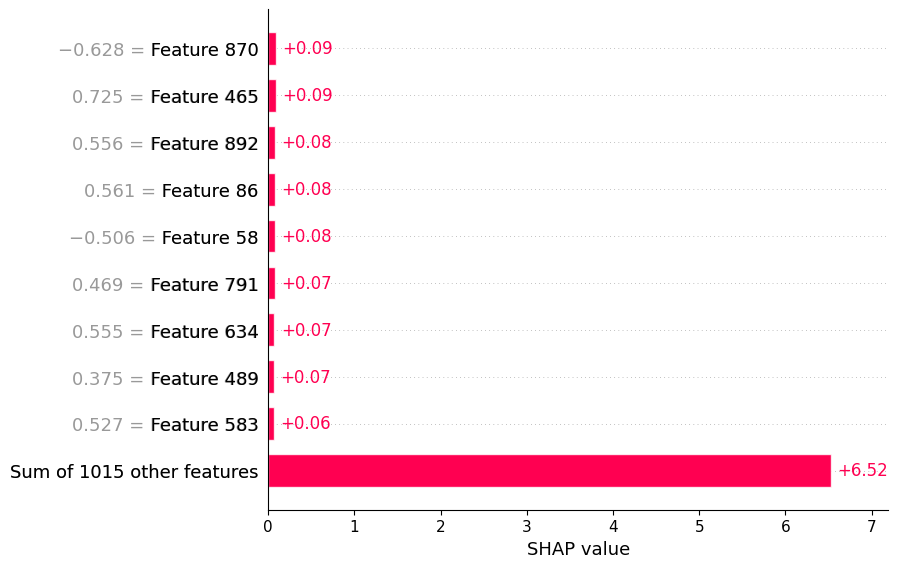

In [288]:
# 입력 데이터 준비
X = torch.from_numpy(xai_feature).float()
X = X.view(-1, 1024)  # [batch_size * 29, 1024]
X = X.to(device)
X.requires_grad = True  # 그래디언트 계산을 위해 필요
# SHAP Explainer 생성
shap_model = ShapModelWrapper(model, xai_label)
explainer = shap.DeepExplainer(shap_model, X)

# SHAP 값 계산
shap_values = explainer.shap_values(X)  # [batch_size * 29, 1024]
# SHAP 값을 [batch_size, 29, 1024]로 변환
shap_values = np.array(shap_values).reshape(-1, 29, 1024)

# 입력 데이터를 [batch_size, 29, 1024]로 복원
X_reshaped = X.view(-1, 29, 1024).cpu().detach().numpy()

# 각 region의 1024 feature에 대한 SHAP 값 시각화
for i in range(shap_values.shape[0]):  # batch_size
    for j in range(shap_values.shape[1]):  # 29 regions
        # SHAP 값 시각화 (예: bar plot)
        shap.plots.bar(shap.Explanation(values=shap_values[i, j], data=X_reshaped[i, j]))
        plt.show()
        break

In [18]:
print(shap.Explanation(values=shap_values[0, 0]))
print(len(shap.Explanation(values=shap_values[0, 0])))

.values =
array([ 0.00376471, -0.03806364, -0.0165262 , ..., -0.02254445,
        0.01124359,  0.05306467])
1024


In [64]:
print(shap.Explanation(values=shap_values[0, 0]).values)

[ 0.00376471 -0.03806364 -0.0165262  ... -0.02254445  0.01124359
  0.05306467]


In [ ]:
for i in range(shap_values.shape[0]):  # batch_size
    for j in range(shap_values.shape[1]):  # 29 regions
        # SHAP 값 시각화 (예: bar plot)
        shap.plots.bar(shap.Explanation(values=shap_values[i, j], data=X_reshaped[i, j]))
        plt.show()
        break

attention map_

## 데이터 추출

In [32]:
import pickle

# Pickle 파일로 저장
with open("raw_train_dict.pkl", "rb") as f:
    df = pickle.load(f)

In [33]:
df.keys()

dict_keys(['mimic_image_file_path', 'bbox_coordinates', 'bbox_labels', 'bbox_phrases', 'bbox_phrase_exists', 'bbox_is_abnormal'])

In [34]:
df_all = pd.read_csv(r"D:\CMU\LSMA\main_project\full_dataset\train.csv")

In [35]:
extract_list = ['D:/CMU/LSMA/main_project/dataset/mimic_jpg_rgrg\\files/p10/p10000980/s50985099/6ad03ed1-97ee17ee-9cf8b320-f7011003-cd93b42d.jpg',
 'D:/CMU/LSMA/main_project/dataset/mimic_jpg_rgrg\\files/p10/p10000980/s51967283/943486a3-b3fa9ff7-50f5a769-7a62fcbb-f39b6da4.jpg',
 'D:/CMU/LSMA/main_project/dataset/mimic_jpg_rgrg\\files/p10/p10000980/s54935705/6ad819bb-bae74eb9-7b663e90-b8deabd7-57f8054a.jpg',
 'D:/CMU/LSMA/main_project/dataset/mimic_jpg_rgrg\\files/p10/p10000980/s54980801/a75a1fbe-802065ad-717eb7c1-e2ce3552-646276a6.jpg',
 'D:/CMU/LSMA/main_project/dataset/mimic_jpg_rgrg\\files/p10/p10000980/s57861150/5aa15ba6-55f5e96e-39cea686-7c3b28b2-b8c97a88.jpg',
 'D:/CMU/LSMA/main_project/dataset/mimic_jpg_rgrg\\files/p10/p10000980/s58206436/54affd39-8bf24209-232bac8a-df6c277a-398ee8a5.jpg',
 'D:/CMU/LSMA/main_project/dataset/mimic_jpg_rgrg\\files/p10/p10000980/s58636672/c7526473-7b7214ee-a5d58d12-29d1f67f-9f4edf00.jpg',
 'D:/CMU/LSMA/main_project/dataset/mimic_jpg_rgrg\\files/p10/p10000980/s59988438/925b9496-a956d7b2-05185e52-bb33313b-c06ee522.jpg']

In [36]:
df_filtered = df_all[df_all['mimic_image_file_path'].isin(extract_list)]

In [40]:
df_filtered.head(1)

,subject_id,study_id,image_id,mimic_image_file_path,bbox_coordinates,bbox_labels,bbox_phrases,bbox_phrase_exists,bbox_is_abnormal
0,10000980,50985099,6ad03ed1-97ee17ee-9cf8b320-f7011003-cd93b42d,D:/CMU/LSMA/main_project/dataset/mimic_jpg_rgr...,"[[225, 144, 512, 553], [406, 171, 512, 550], [...","[1, 2, 3, 6, 19]",['Previous mild pulmonary edema and possible c...,"[True, False, False, False, True, False, True,...","[True, False, False, False, True, False, False..."


메타 데이터 추출

In [41]:
df_meta = pd.read_csv("D:\CMU\LSMA\main_project\mimic_dataset_p\metadata_total_sid.csv")

In [289]:
df_test.head(1)

,subject_id,study_id,image_id,mimic_image_file_path,bbox_coordinates,bbox_labels,bbox_phrases,bbox_phrase_exists,bbox_is_abnormal,reference_report
89,10019777,56013693,dcaead7c-bba30dd7-76fd5755-24ac78ea-2222e886,D:/CMU/LSMA/main_project/dataset/mimic_jpg_rgr...,"[[144, 315, 512, 512], [315, 360, 512, 512], [...","[1, 2, 6, 19]","[""Lung volumes are low resulting crowding of t...","[True, False, True, True, True, False, True, F...","[True, False, True, True, True, False, False, ...",Lung volumes are low resulting crowding of the...


In [290]:
image_id = 'dcaead7c-bba30dd7-76fd5755-24ac78ea-2222e886'

In [291]:
info_data = df_meta[df_meta['ImageID']==image_id]

In [292]:
info_data.head(1)

,ImageID,PatientID,StudyDate,StudyTime,SeriesDate,AcquisitionDate,ContentDate,SeriesTime,AcquisitionTime,ContentTime,AccessionNumber,Procedure,View,StudyID


이미지 데이터 추출

In [45]:
#image_id = '6ad03ed1-97ee17ee-9cf8b320-f7011003-cd93b42d.jpg'

이미지 추출 index 찾기

In [167]:
df_filtered.head(1)

,subject_id,study_id,image_id,mimic_image_file_path,bbox_coordinates,bbox_labels,bbox_phrases,bbox_phrase_exists,bbox_is_abnormal,true_count
0,10000980,50985099,6ad03ed1-97ee17ee-9cf8b320-f7011003-cd93b42d,D:/CMU/LSMA/main_project/dataset/mimic_jpg_rgr...,"[[225, 144, 512, 553], [406, 171, 512, 550], [...","[1, 2, 3, 6, 19]",['Previous mild pulmonary edema and possible c...,"[True, False, False, False, True, False, True,...","[True, False, False, False, True, False, False...",8


In [198]:
df_filtered['bbox_is_abnormal'].iloc[0]

'[True, False, False, False, True, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, True, False, False, True, False, False, False, False]'

In [201]:
df_filtered['bbox_phrase_exists'].iloc[0]

'[True, False, False, False, True, False, True, False, True, False, False, False, True, False, True, False, False, False, False, False, False, True, False, False, True, False, False, False, False]'

In [212]:
matching_indices = []

for _, row in df_filtered.iterrows():
    # 'bbox_phrase_exists' 값을 리스트로 변환
    if isinstance(row['bbox_phrase_exists'], str):
        bbox_phrase_exists = ast.literal_eval(row['bbox_phrase_exists'])
    else:
        bbox_phrase_exists = row['bbox_phrase_exists']
    
    # 'bbox_labels' 값을 리스트로 변환
    if isinstance(row['bbox_labels'], str):
        bbox_labels = ast.literal_eval(row['bbox_labels'])
    else:
        bbox_labels = row['bbox_labels']
    
    # bbox_phrase_exists에서 True인 인덱스 추출
    true_indices = [i for i, value in enumerate(bbox_phrase_exists) if value]
    
    # true_indices와 bbox_labels의 교집합 찾기
    matching_indices = [index if index in bbox_labels else -1 for index in true_indices]
    
    # 결과 출력
    print("True indices:", true_indices)
    print("Matching indices with -1 for non-matching:", matching_indices)
    break  # 첫 번째 행만 처리


True indices: [0, 4, 6, 8, 12, 14, 21, 24]
Matching indices with -1 for non-matching: [-1, -1, 6, -1, -1, -1, -1, -1]


In [293]:
matching_indices = []

for _, row in df_test.iterrows():
    # 'bbox_phrase_exists' 값을 리스트로 변환
    if isinstance(row['bbox_phrase_exists'], str):
        bbox_phrase_exists = ast.literal_eval(row['bbox_phrase_exists'])
    else:
        bbox_phrase_exists = row['bbox_phrase_exists']
    
    # 'bbox_labels' 값을 리스트로 변환
    if isinstance(row['bbox_labels'], str):
        bbox_labels = ast.literal_eval(row['bbox_labels'])
    else:
        bbox_labels = row['bbox_labels']
    
    # bbox_phrase_exists에서 True인 인덱스 추출
    true_indices = [i for i, value in enumerate(bbox_phrase_exists) if value]
    
    # true_indices와 bbox_labels의 교집합 찾기
    matching_indices = [index if index in bbox_labels else -1 for index in true_indices]
    
    # 결과 출력
    print("True indices:", true_indices)
    print("Matching indices with -1 for non-matching:", matching_indices)
    break  # 첫 번째 행만 처리


True indices: [0, 2, 3, 4, 6, 8, 12, 14, 24]
Matching indices with -1 for non-matching: [-1, 2, -1, -1, 6, -1, -1, -1, -1]


In [208]:
image_id

'6ad03ed1-97ee17ee-9cf8b320-f7011003-cd93b42d.jpg'

In [209]:
df_filtered.head(1)

,subject_id,study_id,image_id,mimic_image_file_path,bbox_coordinates,bbox_labels,bbox_phrases,bbox_phrase_exists,bbox_is_abnormal,true_count
0,10000980,50985099,6ad03ed1-97ee17ee-9cf8b320-f7011003-cd93b42d,D:/CMU/LSMA/main_project/dataset/mimic_jpg_rgr...,"[[225, 144, 512, 553], [406, 171, 512, 550], [...","[1, 2, 3, 6, 19]",['Previous mild pulmonary edema and possible c...,"[True, False, False, False, True, False, True,...","[True, False, False, False, True, False, False...",8


In [157]:
path_

'D:/CMU/LSMA/main_project/dataset/mimic_jpg_rgrg\\files/p10/p10000980/s50985099/6ad03ed1-97ee17ee-9cf8b320-f7011003-cd93b42d.jpg'

version1

In [127]:
import ast
import cv2
import numpy as np

def scale_coordinates(coordinates, scaling_factor):
    """
    좌표를 스케일링 팩터에 따라 변환
    """
    scaled_coordinates = []
    for coord in coordinates:
        x1, y1, x2, y2 = coord  # 리스트 또는 튜플에서 언팩
        scaled_x1 = int(x1 * scaling_factor)
        scaled_y1 = int(y1 * scaling_factor)
        scaled_x2 = int(x2 * scaling_factor)
        scaled_y2 = int(y2 * scaling_factor)
        scaled_coordinates.append((scaled_x1, scaled_y1, scaled_x2, scaled_y2))
    return scaled_coordinates

# 이미지 로드
path_ = extract_list[0]
image = cv2.imread(path_)

if image is not None:
    original_size = (512, 615)#(2544, 3056)  # (높이, 너비)
    original_width, original_height = original_size
    max_size = 512  # 목표 최대 크기

    # 스케일링 팩터 계산
    scaling_factor = min(max_size / original_width, max_size / original_height)

    # 새 크기 계산
    new_width = int(original_width * scaling_factor)
    new_height = int(original_height * scaling_factor)

    # 좌표 리스트 가져오기
    coordinates = df_filtered[df_filtered['mimic_image_file_path'] == path_]['bbox_coordinates'].values[0]

    # 문자열로 저장된 좌표를 리스트로 변환
    if isinstance(coordinates, str):
        coordinates = ast.literal_eval(coordinates)  # 문자열을 리스트로 안전하게 변환

    # 좌표 변환
    scaled_coordinates = scale_coordinates(coordinates, scaling_factor)

    # 이미지 리사이즈 (비율 유지)
    resized_image = cv2.resize(image, (new_width, new_height), interpolation=cv2.INTER_AREA)

    # 각 좌표에 대해 별도 이미지 생성
    for i, coord in enumerate(scaled_coordinates):
        # 이미지 복사
        image_copy = resized_image.copy()
        
        # 각 좌표에 대해 네모 그리기
        x1, y1, x2, y2 = coord
        cv2.rectangle(image_copy, (x1, y1), (x2, y2), (0, 255, 0), 2)

        # 수정된 이미지 저장
        cv2.imwrite(f'{image_id}/im_{image_id}_box_{i}.jpg', image_copy)
else:
    print("Failed to load image. Please check the image path.")


In [294]:
image_path_list = []

In [295]:
df_test.head(1)

,subject_id,study_id,image_id,mimic_image_file_path,bbox_coordinates,bbox_labels,bbox_phrases,bbox_phrase_exists,bbox_is_abnormal,reference_report
89,10019777,56013693,dcaead7c-bba30dd7-76fd5755-24ac78ea-2222e886,D:/CMU/LSMA/main_project/dataset/mimic_jpg_rgr...,"[[144, 315, 512, 512], [315, 360, 512, 512], [...","[1, 2, 6, 19]","[""Lung volumes are low resulting crowding of t...","[True, False, True, True, True, False, True, F...","[True, False, True, True, True, False, False, ...",Lung volumes are low resulting crowding of the...


In [297]:
df_filtered=df_test.copy()

In [298]:
import ast
import cv2
import numpy as np

def scale_coordinates(coordinates, scaling_factor):
    """
    좌표를 스케일링 팩터에 따라 변환
    """
    scaled_coordinates = []
    for coord in coordinates:
        x1, y1, x2, y2 = coord  # 리스트 또는 튜플에서 언팩
        scaled_x1 = int(x1 * scaling_factor)
        scaled_y1 = int(y1 * scaling_factor)
        scaled_x2 = int(x2 * scaling_factor)
        scaled_y2 = int(y2 * scaling_factor)
        scaled_coordinates.append((scaled_x1, scaled_y1, scaled_x2, scaled_y2))
    return scaled_coordinates

# 이미지 로드
path_ = df_test['mimic_image_file_path'].iloc[0]
image = cv2.imread(path_)
image_path_list=[]
if image is not None:
    original_size = (512, 615)#(2544, 3056)  # (높이, 너비)
    original_width, original_height = original_size
    max_size = 512  # 목표 최대 크기

    # 스케일링 팩터 계산
    scaling_factor = min(max_size / original_width, max_size / original_height)

    # 새 크기 계산
    new_width = int(original_width * scaling_factor)
    new_height = int(original_height * scaling_factor)

    # 좌표 리스트 가져오기
    coordinates = df_filtered[df_filtered['mimic_image_file_path'] == path_]['bbox_coordinates'].values[0]
    label_index = df_filtered[df_filtered['mimic_image_file_path'] == path_]['bbox_labels'].values[0]
    # 문자열로 저장된 좌표를 리스트로 변환
    if isinstance(coordinates, str):
        coordinates = ast.literal_eval(coordinates)  # 문자열을 리스트로 안전하게 변환
        label_index = ast.literal_eval(label_index)
    # 좌표 변환
    scaled_coordinates = scale_coordinates(coordinates, scaling_factor)

    # 이미지 리사이즈 (비율 유지)
    resized_image = cv2.resize(image, (new_width, new_height), interpolation=cv2.INTER_AREA)

    # 각 좌표에 대해 별도 이미지 생성
    print(matching_indices)
    for idx,num in enumerate(matching_indices):
        if num==-1:
            image_path_list.append(path_)
        else:
            
            print(label_index)
            inner_index = label_index.index(num)
            print(inner_index)
    #for i, coord in enumerate(scaled_coordinates):
        # 이미지 복사
            image_copy = resized_image.copy()
        
        # 각 좌표에 대해 네모 그리기
            x1, y1, x2, y2 = scaled_coordinates[inner_index]
            cv2.rectangle(image_copy, (x1, y1), (x2, y2), (0, 255, 0), 2)

        # 수정된 이미지 저장
            cv2.imwrite(f'{image_id}/im_{image_id}_box_{idx}.jpg', image_copy)
            image_path_list.append(f'{image_id}/im_{image_id}_box_{idx}.jpg')


[-1, 2, -1, -1, 6, -1, -1, -1, -1]
[1, 2, 6, 19]
1
[1, 2, 6, 19]
2


In [236]:
image_id

'6ad03ed1-97ee17ee-9cf8b320-f7011003-cd93b42d.jpg'

In [224]:
matching_indices

[-1, -1, 6, -1, -1, -1, -1, -1]

version2-json

In [235]:
image_id.split('.')[0]

'6ad03ed1-97ee17ee-9cf8b320-f7011003-cd93b42d'

In [171]:
json_path = f"D:/CMU/LSMA/main_project/chest-imagenome-dataset-1.0.0/chest-imagenome-dataset-1.0.0/silver_dataset/scene_graph/{image_id.split('.')[0]}_SceneGraph.json"

In [173]:
import json
def load_json(json_path):
    try:
        with open(json_path, 'r') as f:
            data = json.load(f)
        return data
    except FileNotFoundError:
        print(f"File not found: {json_path}")
        return None
    except json.JSONDecodeError as e:
        print(f"Error decoding JSON: {e}")
        return None

# JSON 로드
json_data = load_json(json_path)

if json_data is not None:
    # JSON 키 확인
    keys = list(json_data.keys())
    print(f"Keys in JSON: {keys}")
else:
    print("Failed to load JSON.")


Keys in JSON: ['image_id', 'viewpoint', 'patient_id', 'study_id', 'gender', 'age_decile', 'reason_for_exam', 'StudyOrder', 'StudyDateTime', 'objects', 'attributes', 'relationships']


In [175]:
len(json_data['objects'])

36

In [179]:
json_data['objects'][30]

{'object_id': '6ad03ed1-97ee17ee-9cf8b320-f7011003-cd93b42d_descending aorta',
 'x1': 109,
 'y1': 58,
 'x2': 140,
 'y2': 122,
 'width': 31,
 'height': 64,
 'bbox_name': 'descending aorta',
 'synsets': ['C0011666'],
 'name': 'Descending aorta',
 'original_x1': 911,
 'original_y1': 523,
 'original_x2': 1191,
 'original_y2': 1101,
 'original_width': 280,
 'original_height': 578}

report 추출

In [128]:
df_filtered.head(1)

,subject_id,study_id,image_id,mimic_image_file_path,bbox_coordinates,bbox_labels,bbox_phrases,bbox_phrase_exists,bbox_is_abnormal
0,10000980,50985099,6ad03ed1-97ee17ee-9cf8b320-f7011003-cd93b42d,D:/CMU/LSMA/main_project/dataset/mimic_jpg_rgr...,"[[225, 144, 512, 553], [406, 171, 512, 550], [...","[1, 2, 3, 6, 19]",['Previous mild pulmonary edema and possible c...,"[True, False, False, False, True, False, True,...","[True, False, False, False, True, False, False..."


In [299]:
import ast

# 결과를 저장할 리스트
report_list = []

# DataFrame에서 각 행 처리
for index, row in df_filtered.iterrows():
    # bbox_phrase_exists와 bbox_phrases 가져오기
    exists_list = row['bbox_phrase_exists']  # 존재 여부 리스트
    phrases = row['bbox_phrases']           # bbox_phrases 리스트

    # phrases가 문자열로 저장된 경우 변환
    if isinstance(phrases, str):
        phrases = ast.literal_eval(phrases)

    # exists_list가 문자열로 저장된 경우 변환
    if isinstance(exists_list, str):
        exists_list = ast.literal_eval(exists_list)

    # True 값이 있는 인덱스를 기준으로 phrases에서 값 추출
    selected_phrases = [phrases[i] for i, exists in enumerate(exists_list) if exists]

    # 결과 리스트에 추가
    report_list.extend(selected_phrases)
    break
# 결과 확인
print("Collected Report List:", report_list)


Collected Report List: ["Lung volumes are low resulting crowding of the pulmonary bronchovascular structures. There is persistent subtle airspace opacity in the right mid to lower lung, this may reflect the residua of the patient's known pneumonia. No pleural effusion seen.", "There is persistent subtle airspace opacity in the right mid to lower lung, this may reflect the residua of the patient's known pneumonia.", "There is persistent subtle airspace opacity in the right mid to lower lung, this may reflect the residua of the patient's known pneumonia.", 'Lung volumes are low resulting crowding of the pulmonary bronchovascular structures.', 'No pleural effusion seen.', 'Lung volumes are low resulting crowding of the pulmonary bronchovascular structures. The left lung is clear. No pleural effusion seen.', 'Lung volumes are low resulting crowding of the pulmonary bronchovascular structures.', 'No pleural effusion seen.', 'The heart is not enlarged.']


In [300]:
path_

'D:/CMU/LSMA/main_project/dataset/mimic_jpg_rgrg\\files/p10/p10019777/s56013693/dcaead7c-bba30dd7-76fd5755-24ac78ea-2222e886.jpg'

In [301]:
len(report_list)

9

In [304]:
g_report_list = ['Right lower lobe pneumonia.','No acute cardiopulmonary process.','There is mild bibasilar atelectasis.','The mediastinal and hilar contours are unremarkable.','There are no acute osseous abnormalities.','There is no pleural effusion or pneumothorax.','','','The cardiomediastinal silhouette is within normal limits.']

In [305]:
len(g_report_list)

9

heatmap 추출하기

In [306]:
import ast

# 'bbox_phrase_exists'의 첫 번째 값 가져오기
bool_list_str = df_filtered['bbox_phrase_exists'].iloc[0]  # 문자열로 저장된 Boolean 리스트

# 문자열을 리스트로 변환
bool_list = ast.literal_eval(bool_list_str)

# True인 값의 인덱스 추출
true_indices = [index for index, value in enumerate(bool_list) if value]

print("True indices:", true_indices)


True indices: [0, 2, 3, 4, 6, 8, 12, 14, 24]


In [307]:
len(true_indices)

9

In [308]:
shap_list=[]
batch_idx = 0
for i in true_indices:
    value = shap.Explanation(values=shap_values[batch_idx, i]).values
    shap_list.append(value)

In [161]:
len(shap_list)

8

In [ ]:
attn_list = []

In [309]:
# load attention map
# .npy 파일 로드
query_importance = np.load('query_importance_test.npy')

# 로드된 데이터 확인
print(query_importance)

[[ 0.0135157   0.00594062  0.02221229 ...  0.01707219 -0.01169649
  -0.00633296]
 [ 0.07377819  0.07370023  0.06124042 ...  0.04621258 -0.04180154
  -0.01192606]
 [ 0.06345376  0.05904688  0.0502959  ...  0.03469085 -0.03922639
  -0.00129224]
 ...
 [ 0.03212516 -0.02036676  0.03368697 ...  0.02506727 -0.0178147
   0.00217101]
 [ 0.00346516 -0.00131598  0.00292954 ...  0.00233859 -0.00386209
   0.0020573 ]
 [ 0.00224976 -0.00054415  0.00630397 ...  0.01140571 -0.00646548
   0.00350887]]


In [310]:
query_importance.shape

(9, 1024)

In [164]:
df_filtered.head(1)

,subject_id,study_id,image_id,mimic_image_file_path,bbox_coordinates,bbox_labels,bbox_phrases,bbox_phrase_exists,bbox_is_abnormal
0,10000980,50985099,6ad03ed1-97ee17ee-9cf8b320-f7011003-cd93b42d,D:/CMU/LSMA/main_project/dataset/mimic_jpg_rgr...,"[[225, 144, 512, 553], [406, 171, 512, 550], [...","[1, 2, 3, 6, 19]",['Previous mild pulmonary edema and possible c...,"[True, False, False, False, True, False, True,...","[True, False, False, False, True, False, False..."


In [165]:
import ast

# 'bbox_phrase_exists' 값이 문자열로 저장된 경우 안전하게 변환
def count_true_in_row(row):
    if isinstance(row, str):
        # 문자열을 리스트로 변환
        row = ast.literal_eval(row)
    # 리스트에서 True 값 개수 세기
    return sum(row)

# 각 행에서 True 값 개수 세기
df_filtered['true_count'] = df_filtered['bbox_phrase_exists'].apply(count_true_in_row)

# 전체 True 값의 총합 계산
total_true_count = df_filtered['true_count'].iloc[:8].sum()

print(f"Total True count: {total_true_count}")


Total True count: 79



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [148]:
attn_list = [ query_importance[i] for i in true_indices ]

In [311]:
attn_list = query_importance

bert score

In [188]:
import os

# 환경 변수 설정
os.environ["HF_HUB_DISABLE_SYMLINKS_WARNING"] = "1"

# Hugging Face 코드 실행
print("Environment variable set successfully!")

Environment variable set successfully!


In [ ]:
import evaluate

# Initialize BERTScore
bert_score = evaluate.load("bertscore")

In [312]:
bert_score_list = []

In [313]:
# Calculate BERTScore for each sentence pair
for gen_sent, ref_sent in zip(g_report_list, report_list):
    bert_score_result = bert_score.compute(
        predictions=[gen_sent],
        references=[ref_sent],
        lang="en",
        model_type="distilbert-base-uncased",
    )
    print(f"Generated: {gen_sent}")
    print(f"Reference: {ref_sent}")
    score =round(bert_score_result['f1'][0],3)
    print(f"BERTScore (F1): {score}")
    bert_score_list.append(score)
    print("-" * 50)

Generated: Right lower lobe pneumonia.
Reference: Lung volumes are low resulting crowding of the pulmonary bronchovascular structures. There is persistent subtle airspace opacity in the right mid to lower lung, this may reflect the residua of the patient's known pneumonia. No pleural effusion seen.
BERTScore (F1): 0.783
--------------------------------------------------
Generated: No acute cardiopulmonary process.
Reference: There is persistent subtle airspace opacity in the right mid to lower lung, this may reflect the residua of the patient's known pneumonia.
BERTScore (F1): 0.747
--------------------------------------------------
Generated: There is mild bibasilar atelectasis.
Reference: There is persistent subtle airspace opacity in the right mid to lower lung, this may reflect the residua of the patient's known pneumonia.
BERTScore (F1): 0.783
--------------------------------------------------
Generated: The mediastinal and hilar contours are unremarkable.
Reference: Lung volumes 

# html

csv정보
사진 이런거 있고 shap있으면서 평가지표도 있으면 좋을 것 같다. . 



In [51]:
df_filtered.head(1)

,subject_id,study_id,image_id,mimic_image_file_path,bbox_coordinates,bbox_labels,bbox_phrases,bbox_phrase_exists,bbox_is_abnormal
0,10000980,50985099,6ad03ed1-97ee17ee-9cf8b320-f7011003-cd93b42d,D:/CMU/LSMA/main_project/dataset/mimic_jpg_rgr...,"[[225, 144, 512, 553], [406, 171, 512, 550], [...","[1, 2, 3, 6, 19]",['Previous mild pulmonary edema and possible c...,"[True, False, False, False, True, False, True,...","[True, False, False, False, True, False, False..."


In [320]:
df_filtered['bbox_phrase_exists'].iloc[0]

'[True, False, True, True, True, False, True, False, True, False, False, False, True, False, True, False, False, False, False, False, False, False, False, False, True, False, False, False, False]'

In [94]:
text_data = df_filtered.iloc[0]['bbox_phrases']

In [314]:
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

output_folder = f"./{image_id}"  # 폴더 이름

# 폴더 생성
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# 정규화 함수
def normalize(values):
    scaler = MinMaxScaler()
    return scaler.fit_transform(values.reshape(-1, 1)).flatten()

# 상위 N개의 값만 유지하면서 순서를 유지하는 함수
def keep_top_n_in_order(values, n):
    # 상위 N개의 값 찾기
    threshold = np.partition(values, -n)[-n]  # 상위 N번째 값
    mask = np.where(values >= threshold, values, 0)  # 상위 N개 값만 유지
    return mask

# 히트맵 저장 함수
def save_heatmap(values, filename):
    plt.figure(figsize=(15, 1))  # 가로로 길게
    sns.heatmap([values], cmap="Blues", cbar=True, xticklabels=False, yticklabels=False)
    plt.axis("off")  # 축 제거
    plt.savefig(filename, bbox_inches="tight", pad_inches=0, format='png')
    plt.close()

# 상위 N개의 값만 포함된 히트맵 생성 및 저장
top_n = 10  # 상위 N개 값

for i, shap_values in enumerate(shap_list):
    # 각 SHAP 값에서 상위 N개의 값만 유지
    bar1_top_n = keep_top_n_in_order(np.abs(shap_values), top_n)
    bar2_top_n = keep_top_n_in_order(attn_list[i], top_n)
    
    # 정규화 적용
    bar1_normalized = normalize(bar1_top_n)
    bar2_normalized = normalize(bar2_top_n)
    
    # 히트맵 파일명 생성
    heatmap1_path = os.path.join(output_folder, f"bar1_heatmap_top{top_n}_{i + 1}.png")
    heatmap2_path = os.path.join(output_folder, f"bar2_heatmap_top{top_n}_{i + 1}.png")
    
    # 히트맵 저장
    save_heatmap(bar1_normalized, heatmap1_path)
    save_heatmap(bar2_normalized, heatmap2_path)

print(f"Heatmaps saved in folder: {output_folder}")


Heatmaps saved in folder: ./dcaead7c-bba30dd7-76fd5755-24ac78ea-2222e886


html

In [315]:
# 예제 데이터
# heatmap_paths 리스트 생성
heatmap_paths = [
    {
        "bar1": f"{output_folder}/bar1_heatmap_top10_{i + 1}.png",
        "bar2": f"{output_folder}/bar2_heatmap_top10_{i + 1}.png"
    }
    for i in range(len(shap_list))  # shap_list 길이만큼 반복
]

# 결과 출력
print("Heatmap paths:", heatmap_paths)


Heatmap paths: [{'bar1': './dcaead7c-bba30dd7-76fd5755-24ac78ea-2222e886/bar1_heatmap_top10_1.png', 'bar2': './dcaead7c-bba30dd7-76fd5755-24ac78ea-2222e886/bar2_heatmap_top10_1.png'}, {'bar1': './dcaead7c-bba30dd7-76fd5755-24ac78ea-2222e886/bar1_heatmap_top10_2.png', 'bar2': './dcaead7c-bba30dd7-76fd5755-24ac78ea-2222e886/bar2_heatmap_top10_2.png'}, {'bar1': './dcaead7c-bba30dd7-76fd5755-24ac78ea-2222e886/bar1_heatmap_top10_3.png', 'bar2': './dcaead7c-bba30dd7-76fd5755-24ac78ea-2222e886/bar2_heatmap_top10_3.png'}, {'bar1': './dcaead7c-bba30dd7-76fd5755-24ac78ea-2222e886/bar1_heatmap_top10_4.png', 'bar2': './dcaead7c-bba30dd7-76fd5755-24ac78ea-2222e886/bar2_heatmap_top10_4.png'}, {'bar1': './dcaead7c-bba30dd7-76fd5755-24ac78ea-2222e886/bar1_heatmap_top10_5.png', 'bar2': './dcaead7c-bba30dd7-76fd5755-24ac78ea-2222e886/bar2_heatmap_top10_5.png'}, {'bar1': './dcaead7c-bba30dd7-76fd5755-24ac78ea-2222e886/bar1_heatmap_top10_6.png', 'bar2': './dcaead7c-bba30dd7-76fd5755-24ac78ea-2222e886/bar2

In [316]:
import os

# 예제 데이터
# output_folder는 절대 경로로 설정
output_folder = os.path.abspath(output_folder)

# heatmap_paths 리스트 생성
heatmap_paths = [
    {
        "bar1": os.path.abspath(f"{output_folder}/bar1_heatmap_top10_{i + 1}.png"),
        "bar2": os.path.abspath(f"{output_folder}/bar2_heatmap_top10_{i + 1}.png")
    }
    for i in range(len(shap_list))  # shap_list 길이만큼 반복
]

# 결과 출력
#print("Heatmap paths:", heatmap_paths)


In [242]:
len(heatmap_paths)

8

In [317]:

# HTML 생성
html_content = f"""
<!DOCTYPE html>
<html lang="en">
<head>
    <meta charset="UTF-8">
    <meta name="viewport" content="width=device-width, initial-scale=1.0">
    <title>HTML Example</title>
    <style>
        .container {{
            display: flex;
            flex-direction: column;
            align-items: center;
        }}
        .row {{
            display: flex;
            align-items: flex-start;
            justify-content: center;
            margin-bottom: 20px;
        }}
        .image-text {{
            display: flex;
            align-items: flex-start;
            margin-bottom: 20px;
        }}
        .image-text img {{
            max-width: 150px;  /* 이미지 크기 조정 */
            margin-right: 20px;
        }}
        .dataframe {{
            margin-bottom: 40px;
        }}
        .heatmap {{
            text-align: center;
            margin-bottom: 20px;
        }}
        .heatmap img {{
            max-width: 100%;
            height: auto;
        }}
    </style>
</head>
<body>
    <div class="container">
        <!-- DataFrame -->
        <div class="dataframe">
            {info_data.to_html(index=False, classes="dataframe")}
        </div>
"""

# 리포트 리스트 길이만큼 반복 추가
for i, (report_text, g_report_text,heatmap) in enumerate(zip(report_list,g_report_list, heatmap_paths)):
    image_path_ = image_path_list[i]#f"{output_folder}/im_{image_id}_box_{i}.jpg"
    html_content += f"""
        <!-- Image and Report Text -->
        <div class="row">
            <div class="image-text">
                <img src="{image_path_}" alt="Image">
                <p>Reference report: {report_text}<br><br>Generate report: {g_report_text}<br><br>Bertsocre:{bert_score_list[i]}</p>
            </div>
        </div>

        <!-- Heatmaps -->
        <div class="heatmap">
            <h3>Region Selection Model</h3>
            <img src="{heatmap['bar1']}" alt="Key Region Extraction Model">
        </div>
        <div class="heatmap">
            <h3>Report Generation Model</h3>
            <img src="{heatmap['bar2']}" alt="Geneartion reportModel">
        </div>
    """

# HTML 마무리
html_content += """
    </div>
</body>
</html>
"""

# 결과 저장
output_file = f"{image_id}/output4.html"
with open(output_file, "w") as f:
    f.write(html_content)

print(f"HTML 파일 생성 완료: {output_file}")


HTML 파일 생성 완료: dcaead7c-bba30dd7-76fd5755-24ac78ea-2222e886/output4.html


In [247]:
image_path_list

['D:/CMU/LSMA/main_project/dataset/mimic_jpg_rgrg\\files/p10/p10000980/s50985099/6ad03ed1-97ee17ee-9cf8b320-f7011003-cd93b42d.jpg',
 'D:/CMU/LSMA/main_project/dataset/mimic_jpg_rgrg\\files/p10/p10000980/s50985099/6ad03ed1-97ee17ee-9cf8b320-f7011003-cd93b42d.jpg',
 '6ad03ed1-97ee17ee-9cf8b320-f7011003-cd93b42d.jpg/im_6ad03ed1-97ee17ee-9cf8b320-f7011003-cd93b42d.jpg_box_2.jpg',
 'D:/CMU/LSMA/main_project/dataset/mimic_jpg_rgrg\\files/p10/p10000980/s50985099/6ad03ed1-97ee17ee-9cf8b320-f7011003-cd93b42d.jpg',
 'D:/CMU/LSMA/main_project/dataset/mimic_jpg_rgrg\\files/p10/p10000980/s50985099/6ad03ed1-97ee17ee-9cf8b320-f7011003-cd93b42d.jpg',
 'D:/CMU/LSMA/main_project/dataset/mimic_jpg_rgrg\\files/p10/p10000980/s50985099/6ad03ed1-97ee17ee-9cf8b320-f7011003-cd93b42d.jpg',
 'D:/CMU/LSMA/main_project/dataset/mimic_jpg_rgrg\\files/p10/p10000980/s50985099/6ad03ed1-97ee17ee-9cf8b320-f7011003-cd93b42d.jpg',
 'D:/CMU/LSMA/main_project/dataset/mimic_jpg_rgrg\\files/p10/p10000980/s50985099/6ad03ed1-97e

In [250]:
image_path_list

['D:/CMU/LSMA/main_project/dataset/mimic_jpg_rgrg\\files/p10/p10000980/s50985099/6ad03ed1-97ee17ee-9cf8b320-f7011003-cd93b42d.jpg',
 'D:/CMU/LSMA/main_project/dataset/mimic_jpg_rgrg\\files/p10/p10000980/s50985099/6ad03ed1-97ee17ee-9cf8b320-f7011003-cd93b42d.jpg',
 'D:/CMU/baseline_code/xai_mimic_report/src/6ad03ed1-97ee17ee-9cf8b320-f7011003-cd93b42d.jpg\\im_6ad03ed1-97ee17ee-9cf8b320-f7011003-cd93b42d.jpg_box_2.jpg',
 'D:/CMU/LSMA/main_project/dataset/mimic_jpg_rgrg\\files/p10/p10000980/s50985099/6ad03ed1-97ee17ee-9cf8b320-f7011003-cd93b42d.jpg',
 'D:/CMU/LSMA/main_project/dataset/mimic_jpg_rgrg\\files/p10/p10000980/s50985099/6ad03ed1-97ee17ee-9cf8b320-f7011003-cd93b42d.jpg',
 'D:/CMU/LSMA/main_project/dataset/mimic_jpg_rgrg\\files/p10/p10000980/s50985099/6ad03ed1-97ee17ee-9cf8b320-f7011003-cd93b42d.jpg',
 'D:/CMU/LSMA/main_project/dataset/mimic_jpg_rgrg\\files/p10/p10000980/s50985099/6ad03ed1-97ee17ee-9cf8b320-f7011003-cd93b42d.jpg',
 'D:/CMU/LSMA/main_project/dataset/mimic_jpg_rgrg\

In [249]:
image_path_list[2]="D:/CMU/baseline_code/xai_mimic_report/src/6ad03ed1-97ee17ee-9cf8b320-f7011003-cd93b42d.jpg\im_6ad03ed1-97ee17ee-9cf8b320-f7011003-cd93b42d.jpg_box_2.jpg"